# Space Invaders own implementation

## Intro 
This is my first try to play the Atari game of SpaceInvaders with the use of tensorflow. Allthough there is some code out there I want to understand it myself. Hence here my own implementation.

## General
- [Stackoverflow]("https://stackoverflow.com/questions/42605769/openai-gym-atari-on-windows") about running Atari on Windows


## about OpenAI
- [Doku]("https://gym.openai.com/docs/")

## Step 1: Import the libraries

In [39]:
import gym 
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import transform
import numpy as np
from collections import deque

## Step 2: Create the environment

In [31]:
env = gym.make('SpaceInvaders-v0')
env.reset()
env.render()

True

In [32]:
# let's check if it works
for i_episode in range(10):
    observation = env.reset()
    for t in range(100):
        env.render()
        observation
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("finisched")
            break

## Step 3: Define the preprocessing functions
In this case we are receiving the fully coloered pictures. Even with the scores on top.


__Observation:__ Here we receive the image.

observation shape  (210, 160, 3)
reward 0.0


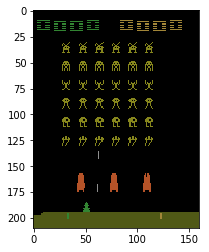

In [33]:
print("observation shape ", observation.shape)
plt.imshow(observation)
print("reward", reward)

In [34]:
def preProcessImage(observation):
    img = rgb2gray(observation) 
    img = img[20:-12,4:-12] # crop image
    img = img / 255 # normalize image
    img = transform.rescale(img, 1/1.9)
    return img

In [35]:
# stack 4 pictures 
# this is important so that the ai 
# is able to understand how the oponents move
img = preProcessImage(observation)
print("shape after processing", img.shape)

shape after processing (94, 76)


C:\Users\wilhe\Miniconda3\envs\gym3\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
C:\Users\wilhe\Miniconda3\envs\gym3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\wilhe\Miniconda3\envs\gym3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [49]:
stack_size = 4

frames = deque(maxlen=4)

def stackPictures(frames, newFrame, isNewEpisode):
    
    if isNewEpisode:
        

## Step 4: Setup Hyper Parameters

## Step 5: Setup Deep Learning

## Step 6: Experience Replay
[Experience Replay]("https://datascience.stackexchange.com/questions/20535/what-is-experience-replay-and-what-are-its-benefits")

## Step 7: Set up Tensorboard 
[Tutorial]("https://www.youtube.com/embed/eBbEDRsCmv4")

## Step 8: Train your Agent

## Step 9: Test